In [ ]:
import json
import requests
import tensorflow as tf
from tensorflow import  keras
from tensorflow.keras import layers
#from tensorflow.contrib import lite
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=500')
data = pd.DataFrame(json.loads(res.content)['Data'])

In [ ]:
data = data.set_index('time')
data.index = pd.to_datetime(data.index, unit='s')
data.head(5)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2019-12-21,7213.86,7132.82,7203.41,12101.12,8.686484e+07,7159.47,direct,
2019-12-22,7527.40,7143.17,7159.47,27325.26,2.005866e+08,7517.58,direct,
2019-12-23,7694.65,7275.28,7517.58,44770.93,3.364250e+08,7326.60,direct,
2019-12-24,7429.42,7175.50,7326.60,27770.75,2.030134e+08,7260.91,direct,
2019-12-25,7280.52,7132.30,7260.91,15012.21,1.085133e+08,7202.72,direct,


In [ ]:
target_col = data['close']
len(target_col)
target_col

time
2019-12-21     7159.47
2019-12-22     7517.58
2019-12-23     7326.60
2019-12-24     7260.91
2019-12-25     7202.72
                ...   
2021-04-30    57757.97
2021-05-01    57843.16
2021-05-02    56623.51
2021-05-03    57195.07
2021-05-04    56108.65
Name: close, Length: 501, dtype: float64

In [ ]:
target_col.describe()

count      501.000000
mean     20289.575749
std      17327.126371
min       4916.780000
25%       9160.390000
50%      10929.400000
75%      28889.610000
max      63558.480000
Name: close, dtype: float64

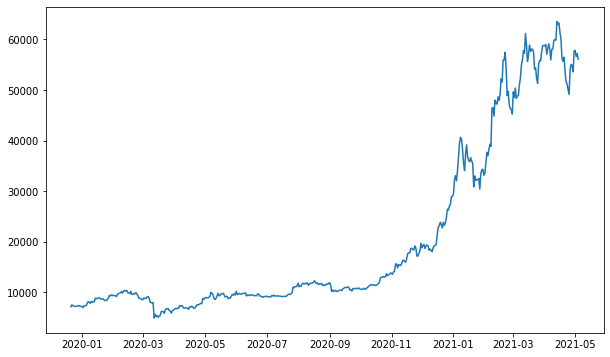

In [ ]:
plt.rcParams['figure.figsize'] = [10,6]
plt.plot(target_col)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
target_col=scaler.fit_transform(np.array(target_col).reshape(-1,1))

In [ ]:
##splitting dataset into train and test split
training_size=int(len(target_col)*0.80)
test_size=len(target_col)-training_size
train_data,test_data=target_col[0:training_size,:],target_col[training_size:len(target_col),:1]

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step=1
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(398, 1)
(398,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(99, 1)
(99,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
model=keras.Sequential()
model.add(LSTM(500,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(500,return_sequences=True))
model.add(LSTM(500,return_sequences=False))
model.add(Dropout(0.2))
model.add(Activation('sigmoid'))
model.add(Dense(1))
#opt = keras.optimizers.Adam(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mse'])
model.compile(loss='mean_squared_error',optimizer='adam', metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 500)            1004000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 500)            2002000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 500)               2002000   
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
activation (Activation)      (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 501       
Total params: 5,008,501
Trainable params: 5,008,501
Non-trainable params: 0
______________________________________________

In [ ]:
history=model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=20,batch_size=32,verbose=1)

Epoch 1/20
13/13 [==============================] - 6s 162ms/step - loss: 0.0422 - mae: 0.1598 - val_loss: 0.3443 - val_mae: 0.5704
Epoch 2/20
13/13 [==============================] - 1s 42ms/step - loss: 0.0216 - mae: 0.1215 - val_loss: 0.4032 - val_mae: 0.6202
Epoch 3/20
13/13 [==============================] - 1s 42ms/step - loss: 0.0168 - mae: 0.0962 - val_loss: 0.3642 - val_mae: 0.5901
Epoch 4/20
13/13 [==============================] - 1s 42ms/step - loss: 0.0096 - mae: 0.0663 - val_loss: 0.1141 - val_mae: 0.3296
Epoch 5/20
13/13 [==============================] - 1s 41ms/step - loss: 0.0023 - mae: 0.0315 - val_loss: 0.0232 - val_mae: 0.1477
Epoch 6/20
13/13 [==============================] - 1s 43ms/step - loss: 0.0011 - mae: 0.0186 - val_loss: 0.0129 - val_mae: 0.1058
Epoch 7/20
13/13 [==============================] - 1s 44ms/step - loss: 3.7233e-04 - mae: 0.0123 - val_loss: 0.0049 - val_mae: 0.0604
Epoch 8/20
13/13 [==============================] - 1s 45ms/step - loss: 1.618

In [ ]:
history.history['loss']

[0.03191959112882614,
 0.018243372440338135,
 0.014717623591423035,
 0.009163795970380306,
 0.0015256005572155118,
 0.0005994651583023369,
 0.0002838505315594375,
 0.00020431107259355485,
 0.00016604272241238505,
 0.00015689247811678797,
 0.00014251841639634222,
 0.00016275570669677109,
 0.000160191222676076,
 0.00011929321772186086,
 0.0001646284363232553,
 0.000203924355446361,
 0.00019159115618094802,
 0.0001174519638880156,
 0.00013711779320146888,
 0.00019837942090816796]

In [ ]:
trace1 = go.Scatter(
    x = np.arange(0, len(history.history['loss']), 1),
    y = history.history['loss'],
    mode = 'lines',
    name = 'Train loss',
    line = dict(color=('rgb(255,0,0)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_loss']), 1),
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Test loss',
    line = dict(color=('rgb(1, 0, 255)'), width=2)
)

data = [trace1, trace2]
layout = go.Layout(
    autosize=False,
    width=750,
    height=600,

    title = 'Train and Test Loss during training',
    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True,
                          title = "Epoch number",
                          color = 'black'
                          ),

    yaxis= go.layout.YAxis(linecolor = 'red',
                          linewidth = 1,
                          mirror = True,
                          title = "Loss",
                           color = 'black'),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='training_process')

In [ ]:
trace1 = go.Scatter(
    x = np.arange(0, len(history.history['mae']), 1),
    y = history.history['mae'],
    mode = 'lines',
    name = 'Train Mean Absolute Error',
    line = dict(color=('rgb(0,0,139)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_mae']), 1),
    y = history.history['val_mae'],
    mode = 'lines',
    name = 'Test Mean Absolute Error',
    line = dict(color=('rgb(1, 0, 0)'), width=2)
)

data = [trace1, trace2]
layout = go.Layout(
    autosize=False,
    width=750,
    height=600,

    title = 'Train and Test Mean Squared Error during training',
    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True,
                          title = "Epoch number",
                          color = 'black'
                          ),

    yaxis= go.layout.YAxis(linecolor = 'red',
                          linewidth = 1,
                          mirror = True,
                          title = "Mean Absolute Error",
                           color = 'black'),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='training_process')

In [ ]:
# add one additional data point to align shapes of the predictions and true labels
#X_test = np.append(X_test, scaler.transform(data.iloc[-1][0]))
#X_test = np.reshape(X_test, (len(X_test), 1, 1))

# get predictions and then make some transformations to be able to calculate RMSE properly in USD
prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(ytest.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

In [ ]:
trace1 = go.Scatter(
    x = np.arange(0, len(prediction2_inverse), 1),
    y = prediction2_inverse,
    mode = 'lines',
    name = 'Predicted Labels',
    line = dict(color=('rgb(0,0,139)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(Y_test2_inverse), 1),
    y = Y_test2_inverse,
    mode = 'lines',
    name = 'True labels',
    line = dict(color=('rgb(255, 0, 0)'), width=2)

)
data = [trace1, trace2]

layout = go.Layout(
    autosize=False,
    width=750,
    height=600,

    title = 'Prediction Graph',
    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True,
                          title = "Number of days",
                          color = 'black'
                          ),                          

    yaxis= go.layout.YAxis(linecolor = 'red',
                          linewidth = 1,
                          mirror = True,
                          title = "Price in USD",
                           color = 'black'),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')
plt.savefig('demonstrating0.png', dpi=300, transparent=False, bbox_inches='tight')


<Figure size 720x432 with 0 Axes>